# CNN (Convolutional neural network)
----
## Use CNN to classify the pictures.
Original data contain images and train/test csv file recording the location of people's face in each image.After proprocessing the image, we have the train and test dataset containing people's face image and label about wearing mask or not. With this dataset, we construct the CNN network to classify the person's wearing mask status.  

We show the learning curve of loss and accuracy in each epoch and plot the confusion matrix to analyze the model. Final, we show a sample of original image with the predict label on it.  

Also, there are many ways in preprocessing the original images, transforming the data, and setting the hyper-parameters. We compare the results in different ways and show in the reports


### 1. Import modules

In [20]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from collections import OrderedDict

#from modules.network import Network
from modules.run_builder import RunBuilder
from modules.preprocess import Preprocess
from modules.dataset import MaskDataset
from modules.run_manager import RunManager
from modules.line_plot import line_plot
from modules.confusion_matrix import ConfusionMatrix
from modules.show_label import show_label_on_image

torch.set_grad_enabled(True)

### 2. Preprocessing
The raw data contains a images folder and train/test.csv. In the images folder, there are 684 images. Each image can be cut into many people's face images through the train/test.csv recording the location of people's face in the image.These people's face images are our training and testing data.  
&nbsp;  
However, the people's face images size are not the same, so we have to do some preprocesses. We consider 3 ways to make our image size the same.  
1. Resize：It's the most convenient way to solve the problem, but the objects in the image would be distorted.
2. Pad and Resize：Make the image to be square by padding 0 to the images, and then resize.
3. Crop and Resize：Make the image to be square by crop the images, and then resize.  

Set the modify parameter in class Preprocess could select the way to make our image size the same. We can try the 3 ways and compare the effct of them, and the result would show in the report.

In [21]:
Preprocess(root='.', train=True, download=False, modify="not_modify")
Preprocess(root='.', train=False, download=False, modify="not_modify")

### 3. Dataset
Make our custom dataset inherit Dataset in Pytorch and override the following methods:

1. `__init__` : Initialize file paths or a list of file names.
2. `__getitem__` : To make dataset can be used to get the sample by index.
3. `__len__` : Returns the size of dataset.  

To inherit Dataset, we can use transfrom in torchvision to crop, flip, normalize.... Also, we can use Dataloader to get batch data in the training stage later.  

By setting the transform parameter in class MaskDataset could transform the images in many ways. We can try some ways and compare the effct of them, and the result would show in the report.

In [22]:
train_set = MaskDataset(
    root='.',
    train=True,
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomCrop((28, 28)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

In [23]:
test_set = MaskDataset(
    root='.',
    train=False,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

### 4. Network
Construct our network and inherit nn.Module in Pytorch and override the following methods:
1. `__init__` : Use layers in torch.nn module to construct our network.  
2. `__forward__` : Call the layer to define the forward function.  

Our CNN contains two parts. The first part is consist of convolution layers and maxpool layers. The second part is full connected part, and it contains linear layers and activation layers.

The weights and biases in the layers are parameters which are auto setted by the network. However, the hyper-parameters including number of neurons in each layers, stride and padding in convolution layers should be set by ourselves.  

Change the stride and pad setting of convolution and maxpool layers in the network could make the different results. We can try the parameter settings and compare the effct of them, and the result would show in the report.

In [24]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=9*4*4, out_features=72)
        self.fc2 = nn.Linear(in_features=72, out_features=48)
        self.fc3 = nn.Linear(in_features=48, out_features=12)
        self.out = nn.Linear(in_features=12, out_features=3)

    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.fc1(t.reshape(-1, 9*4*4)))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)

        return t

### 5. Train the model
First, set the hyper-parameters including batch size, learning rate.... Then, we use adam optimizer to train our model.  

In the training stage, we use the run_manager constructed by ourselves to record the data in each epoch and show the dataframe to know the loss and accuracy. It may heip us to analyze the results later.  

Also, we can set many hyper-parameters, and compare the results between each run.

In [ ]:
# set device
print(f"Gpu available : {torch.cuda.is_available()}")
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# constant hyper-parameter
num_workers = 0
epochs_each_run = 200

# variable hyper-parameter
params = OrderedDict(
    lr=[.007],
    batch_size=[500],
    #num_workers=[0],
    #device=['cuda'],
)

m = RunManager()
for run in RunBuilder.get_runs(params):
    print(run)
    #device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(train_set, batch_size=run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs_each_run):
        m.begin_epoch()
        for batch in loader:
            images = batch[0].to(device)
            labels = batch[1].to(device)

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()  # Gradients
            optimizer.step()  # Update Weights

            m.track_loss(loss, batch)
            m.track_num_correct(preds, labels)

        with torch.no_grad():
            test_loader = DataLoader(test_set,
                                     batch_size=len(test_set.targets))
            for test_batch in test_loader:
                test_imgs = test_batch[0].to(device)
                test_labels = test_batch[1].to(device)
                test_preds = network(test_imgs)
                test_loss = F.cross_entropy(test_preds, test_labels)

                m.track_test_loss(test_loss, test_imgs)
                m.track_test_accuracy(test_preds, test_labels)
        m.end_epoch()
    m.end_run()

Gpu available : True
Run(lr=0.007, batch_size=500)
epoch:25	train_acc:0.930	test_acc:0.914
epoch:50	train_acc:0.938	test_acc:0.921


In [14]:
pd.DataFrame(m.run_data).sort_values('train_acc', ascending=False).head(20)

,run,epoch,train_loss,train_acc,test_loss,test_acc,epoch duration,run duration,lr,batch_size
1,1,2,0.597303,0.806689,0.798466,0.718274,1.480867,2.836475,0.007,500
2,1,3,0.558362,0.806689,0.708698,0.718274,1.458173,4.294648,0.007,500
0,1,1,0.865017,0.598073,0.733829,0.718274,1.355608,1.355608,0.007,500


### 6. Learning curve
Use the data recorded in run manager, show the line plot to understand the change of loss and accuracy  as the epoch increases including training and testing dataset.  

Also, it can show the plot in different hyper-parameter setting to compare the results in dufferent situations.

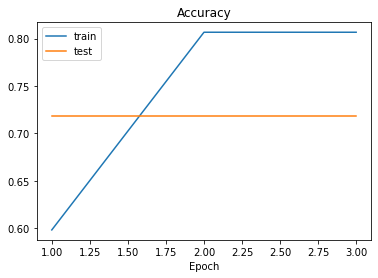

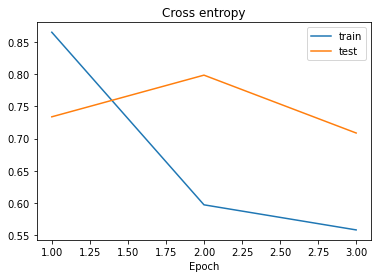

In [15]:
df_all = pd.DataFrame(m.run_data)

ys = {'train':df_all['train_acc'], 'test':df_all['test_acc']}
line_plot.learning_curve(df_all['epoch'], ys, title="Accuracy")

ys = {'train':df_all['train_loss'], 'test':df_all['test_loss']}
line_plot.learning_curve(df_all['epoch'], ys, title="Cross entropy")

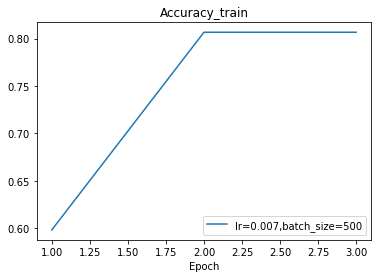

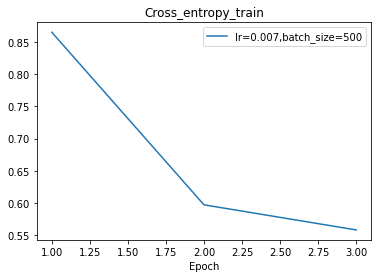

In [16]:
line_plot.hparams_learning_curve(df_all, y='train_acc', 
                                 label=('lr','batch_size'), title="Accuracy_train")

line_plot.hparams_learning_curve(df_all, y='train_loss', 
                                 label=('lr','batch_size'), title="Cross_entropy_train")

### 7. Confusion matrix
Show the confusion matrix of the training and testing prediction results, and plot it. It makes us to know the model's prediction situations between the three type of classes.  

Furthermore, we show the accuracies in each ture classes. Example: In the 100 true 'good' data, the model predict 97 'good' and 3 not 'good'. Knowing which classes predict the worst, we can try to adjust the dataset or model to make the results better. The comparison results would show in the report.

Confusion matrix, without normalization


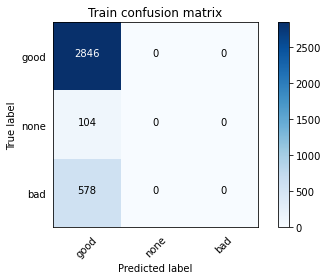

Confusion matrix, without normalization


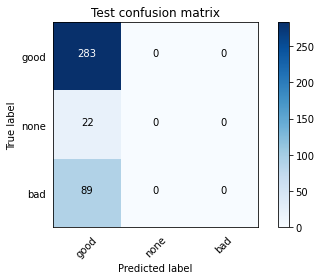

In [17]:
with torch.no_grad():
    train_loader = DataLoader(train_set, batch_size=1000)
    train_preds = ConfusionMatrix.get_all_preds(network, train_loader)

    test_loader = DataLoader(test_set, batch_size=1000)
    test_preds = ConfusionMatrix.get_all_preds(network, test_loader)

train_cm = ConfusionMatrix.get_confusion_matrix(
    train_set.targets, train_preds, len(train_set.classes))
test_cm = ConfusionMatrix.get_confusion_matrix(
    test_set.targets, test_preds, len(test_set.classes))

ConfusionMatrix.plot_confusion_matrix(train_cm,
                                      train_set.classes,
                                      title='Train confusion matrix')
ConfusionMatrix.plot_confusion_matrix(test_cm,
                                      test_set.classes,
                                      title='Test confusion matrix')

In [18]:
cm_dict = {'Train':train_cm, 'Test':test_cm}
classes_acc_df = ConfusionMatrix.get_classes_acc(cm_dict, train_set.classes)
classes_acc_df.round(2)

,Train,Test
good,1.0,1.0
none,0.0,0.0
bad,0.0,0.0


### 8. Results
Randomly sample some images contain many people's face , and show the predict lable of them in the imges.

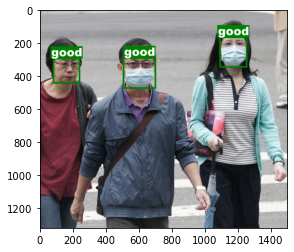

In [19]:
with torch.no_grad():
    train_loader = DataLoader(train_set, batch_size=1000)
    train_preds = ConfusionMatrix.get_all_preds(network.to('cpu'), train_loader)

show_label_on_image(root=".", all_preds=train_preds, train=True, 
                    filename='5db917bb89170.jpg', fontsize=70)